In [3]:
import pandas as pd
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import PC
from castle.common.priori_knowledge import PrioriKnowledge

import networkx as nx
from dowhy import gcm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#Causal graph
causal_graph = nx.DiGraph([('d', 'messageReceived'),
                           ('d', 'graft'),
                           ('d', 'prune'),
                           ('d', 'iwant'),
                           ('dlo', 'graft'),
                           ('dhi', 'prune'),
                           ('dscore', 'graft'),
                           ('dscore', 'prune'),
                           ('dlazy', 'iwant'),
                           ('dlazy', 'ihave'),
                           ('dout', 'graft'),
                           ('dout', 'prune'),
                           ('gossipFactor', 'iwant'),
                           ('gossipFactor', 'ihave'),
                           ('interval', 'graft'),
                           ('interval', 'prune'),
                           ('interval', 'iwant'),
                           ('interval', 'ihave'),
                           ('topology', 'graft'),
                           ('topology', 'prune'),
                           ('topology', 'propagationTime'),
                           ('topology', 'messageReceived'),
                           ('prune', 'graft'),
                           ('prune', 'propagationTime'),
                           ('messageReceived', 'messageOverhead'),
                           ('messageOverhead', 'bandwidth'),
                           ('iwant', 'bandwidth'),
                           ('ihave', 'bandwidth'),
                           ('messageReceived', 'bandwidth')
                         ])

In [18]:
#From digraph to adjancency matrix

# true_causal_matrix = nx.adjacency_matrix(causal_graph)
true_causal_matrix = nx.to_numpy_array(causal_graph)

print(true_causal_matrix)

[[0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [15]:
#Treat dataset

#Import data 
data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)

consolidated = consolidated.drop(columns=['identifier', 'n_nodes'])
consolidated = consolidated.rename(columns={'topology':'top'})
consolidated['topology'] = 0
consolidated.loc[consolidated['top'] == 'general', 'topology'] = 1
consolidated = consolidated.drop(columns=['top'])
# consolidated.head(100)

X = consolidated.to_numpy()
print(X)

[[8.000e+00 6.000e+00 1.200e+01 4.000e+00 8.000e+00 2.000e+00 2.500e-01
  1.000e+00 3.023e+00 2.149e+03 1.262e+06 1.830e+03 1.682e+06 2.425e+05
  1.537e+03 1.250e+02 1.700e+01 1.098e+05 0.000e+00]
 [8.000e+00 6.000e+00 1.200e+01 4.000e+00 8.000e+00 2.000e+00 2.500e-01
  3.000e+00 3.026e+00 2.160e+03 1.220e+06 1.606e+03 1.844e+06 1.645e+05
  2.137e+03 0.000e+00 1.000e+00 4.868e+03 0.000e+00]
 [1.600e+01 8.000e+00 2.000e+01 1.600e+01 8.000e+00 4.000e+00 5.000e-01
  1.000e+00 3.028e+00 2.009e+03 9.919e+05 1.300e+03 1.428e+06 1.244e+05
  2.138e+03 0.000e+00 0.000e+00 7.920e+02 0.000e+00]
 [1.600e+01 8.000e+00 2.000e+01 1.600e+01 8.000e+00 4.000e+00 5.000e-01
  5.000e-01 3.074e+00 6.675e+03 3.889e+05 6.215e+02 7.629e+05 1.561e+05
  1.387e+03 1.350e+02 1.200e+01 7.145e+04 0.000e+00]
 [6.000e+00 4.000e+00 8.000e+00 2.000e+00 2.000e+00 2.000e+00 2.500e-01
  1.000e+00 3.039e+00 3.089e+03 8.594e+05 1.363e+03 1.778e+06 3.519e+05
  1.469e+03 3.080e+02 4.600e+01 1.418e+05 0.000e+00]
 [6.000e+00 4.0

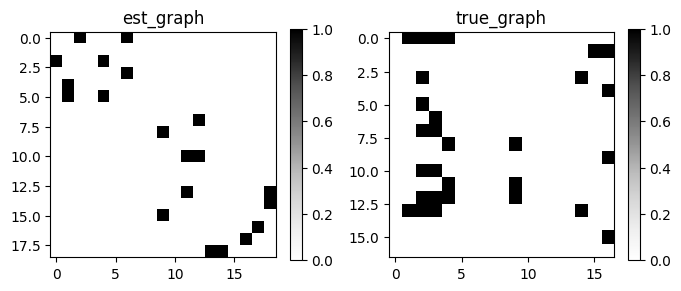

IndexError: index 17 is out of bounds for axis 0 with size 17

In [19]:
# structure learning
pc = PC()
pc.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc.causal_matrix, true_causal_matrix)
print(mt.metrics)